In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm


In [2]:
csv_file = "data/customers-2000000.csv"

# Define chunk size (number of rows per batch)
chunksize = 1_000_000

city_counts = {}       # {country: {city: count}}
company_counts = {}    # {company: count}
monthly_counts = {}    # {country: {YearMonth: count}}

for chunk in pd.read_csv(csv_file, chunksize=chunksize, parse_dates=['Subscription Date']):

    #  City counts per country
    for (country, city), count in chunk.groupby(['Country', 'City']).size().items():
        if country not in city_counts:
            city_counts[country] = {}
        city_counts[country][city] = city_counts[country].get(city, 0) + count

    # Company counts
    for company, count in chunk['Company'].value_counts().items():
        company_counts[company] = company_counts.get(company, 0) + count

    # Monthly counts per country
    chunk['YearMonth'] = chunk['Subscription Date'].dt.to_period('M')
    for (country, ym), count in chunk.groupby(['Country', 'YearMonth']).size().items():
        if country not in monthly_counts:
            monthly_counts[country] = {}
        monthly_counts[country][ym] = monthly_counts[country].get(ym, 0) + count

# DataFrames for analysis
city_rows = []
for country, cities in city_counts.items():
    for city, count in cities.items():
        city_rows.append({'Country': country, 'City': city, 'Total': count})
city_counts_df = pd.DataFrame(city_rows).sort_values(['Country', 'Total'], ascending=[True, False])

company_counts_df = pd.DataFrame(list(company_counts.items()), columns=['Company', 'Total']).sort_values('Total', ascending=False)

monthly_rows = []
for country, months in monthly_counts.items():
    for ym, count in months.items():
        monthly_rows.append({'Country': country, 'YearMonth': ym, 'MonthlyCount': count})
monthly_counts_df = pd.DataFrame(monthly_rows).sort_values(['Country', 'YearMonth'])



In [14]:

df =pd.read_csv(csv_file)

# Assuming df, company_counts_df, city_counts_df, monthly_counts_df are already defined

# Total memory of the full CSV DataFrame
total_csv_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)

# Total memory of all summary DataFrames combined
total_summary_memory = (
    company_counts_df.memory_usage(deep=True).sum() +
    city_counts_df.memory_usage(deep=True).sum() +
    monthly_counts_df.memory_usage(deep=True).sum()
) / (1024 ** 2)

print(f"Full CSV memory usage: {total_csv_memory:.2f} MB")
print(f"Total summary DataFrames memory usage: {total_summary_memory:.2f} MB")
print(f"Memory reduction: {100 * (1 - total_summary_memory / total_csv_memory):.2f}%")


Full CSV memory usage: 1506.04 MB
Total summary DataFrames memory usage: 368.66 MB
Memory reduction: 75.52%


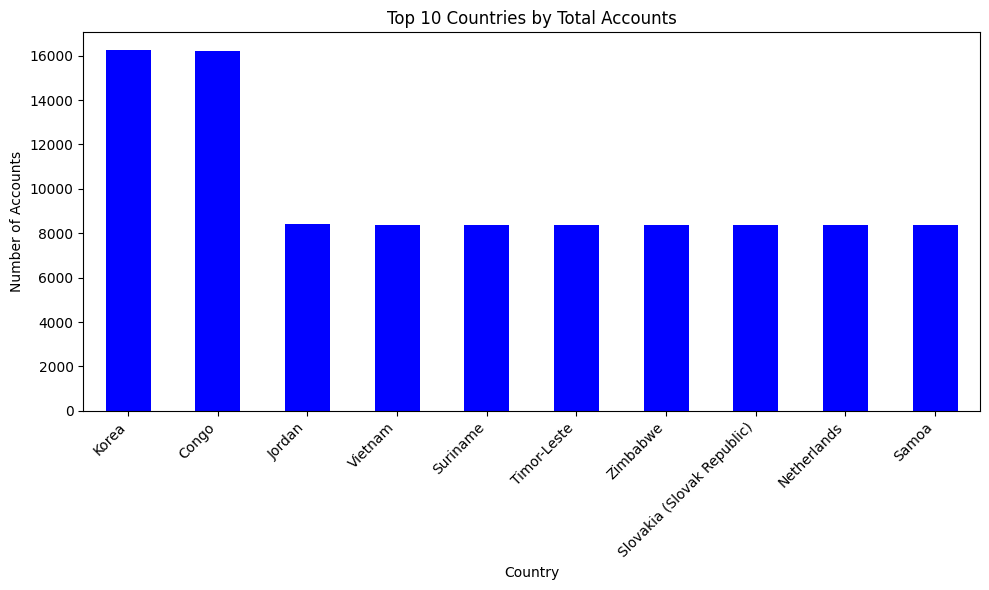

In [4]:
top_n = 10
accounts_per_country = city_counts_df.groupby('Country')['Total'].sum()
top_countries = accounts_per_country.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10,6))
top_countries.plot(kind='bar', color='blue')
plt.title(f'Top {top_n} Countries by Total Accounts')
plt.xlabel('Country')
plt.ylabel('Number of Accounts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

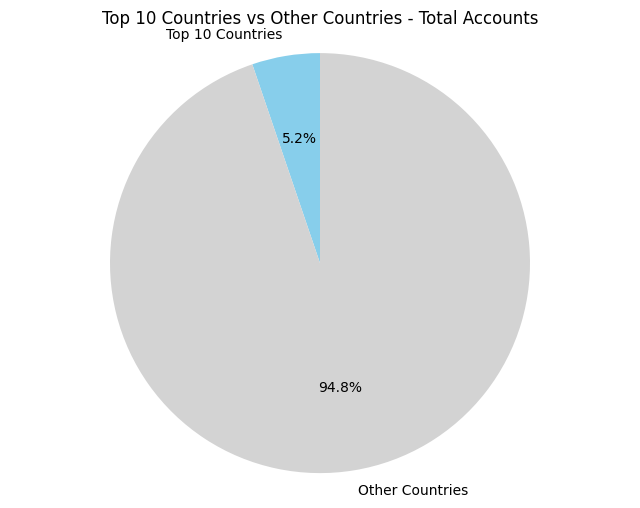

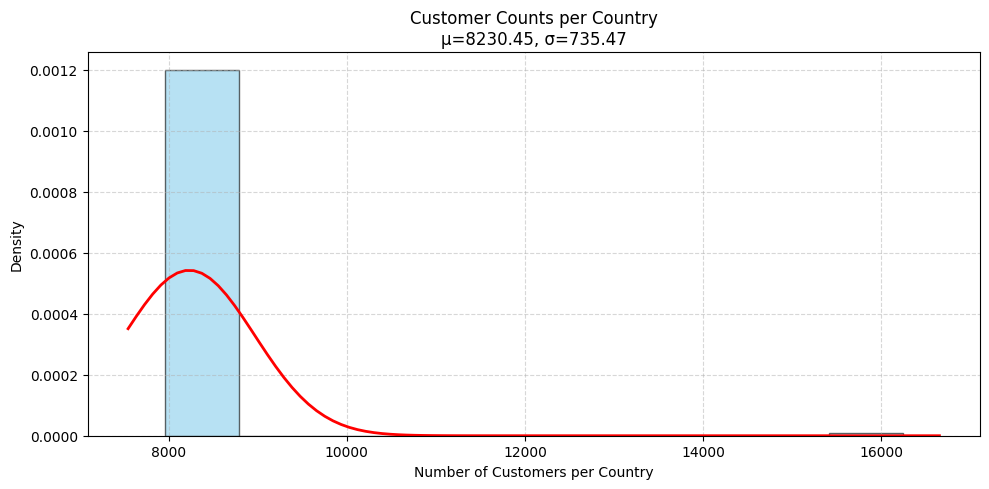

In [13]:

top_k = int(0.1*len(accounts_per_country))
top_countries_sum = top_countries.sum()

other_sum = accounts_per_country.iloc[top_k:].sum()

pie_data = [top_countries_sum, other_sum]
labels = [f'Top 10 Countries', 'Other Countries']

# Plot
plt.figure(figsize=(8,6))
plt.pie(pie_data, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightgray'], startangle=90)
plt.title(f'Top 10 Countries vs Other Countries - Total Accounts')
plt.axis('equal') 
plt.show()


mu = accounts_per_country.mean()
std = accounts_per_country.std()


plt.figure(figsize=(10,5))
plt.hist(accounts_per_country, bins=10, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

plt.title(f'Customer Counts per Country\nμ={mu:.2f}, σ={std:.2f}')
plt.xlabel('Number of Customers per Country')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

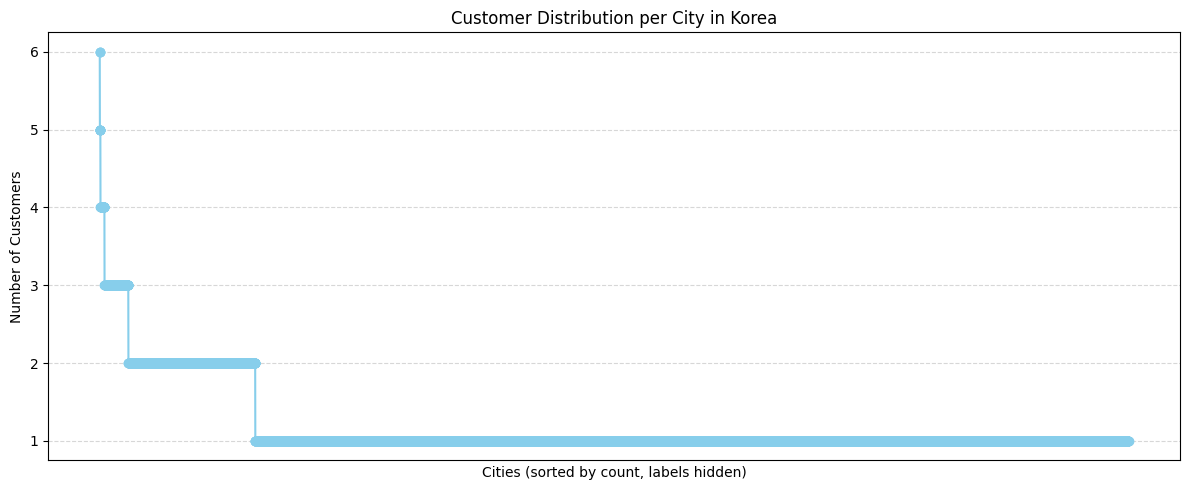

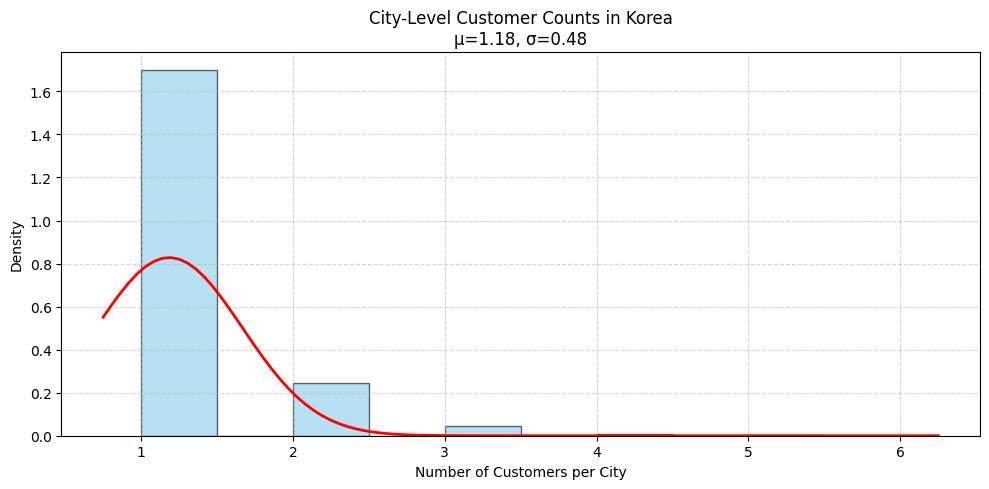

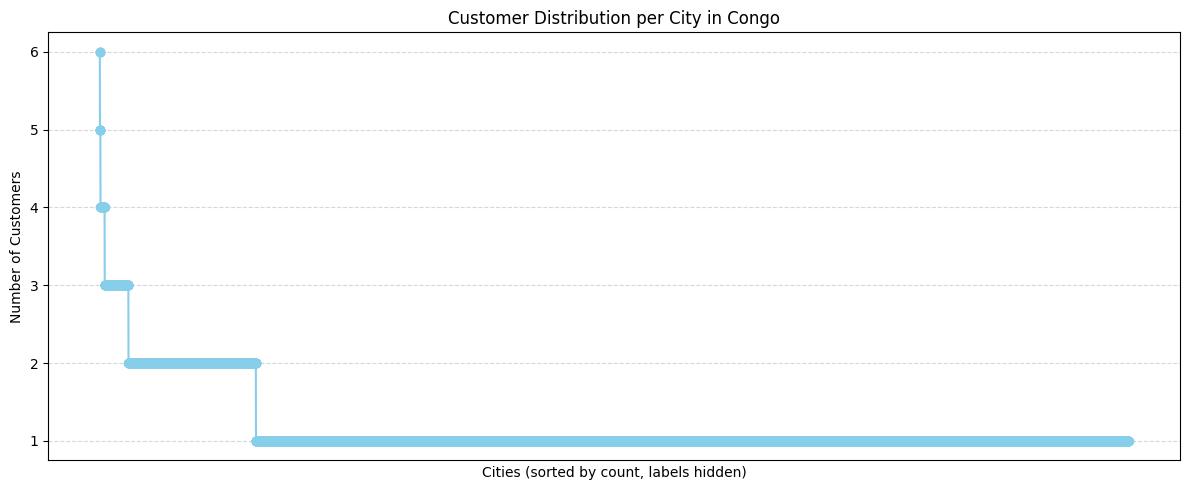

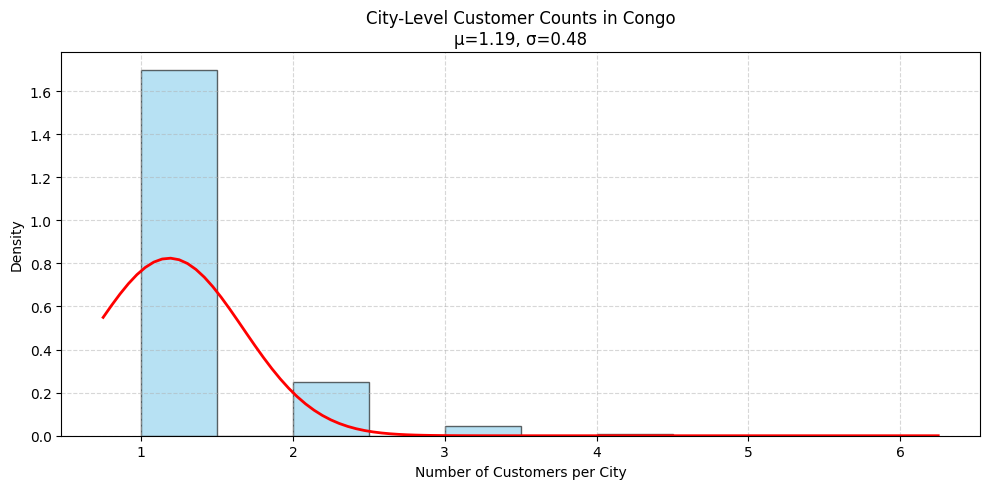

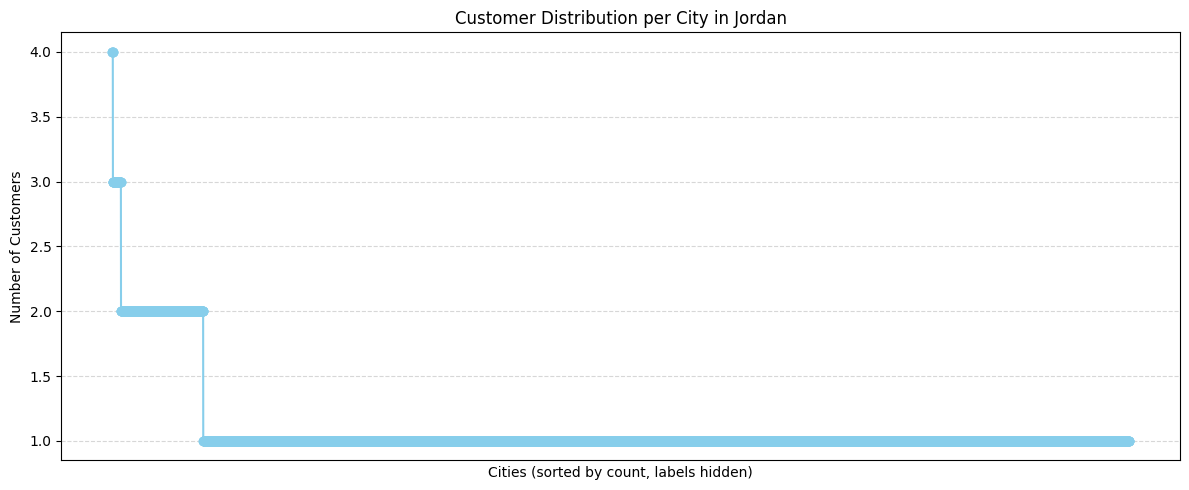

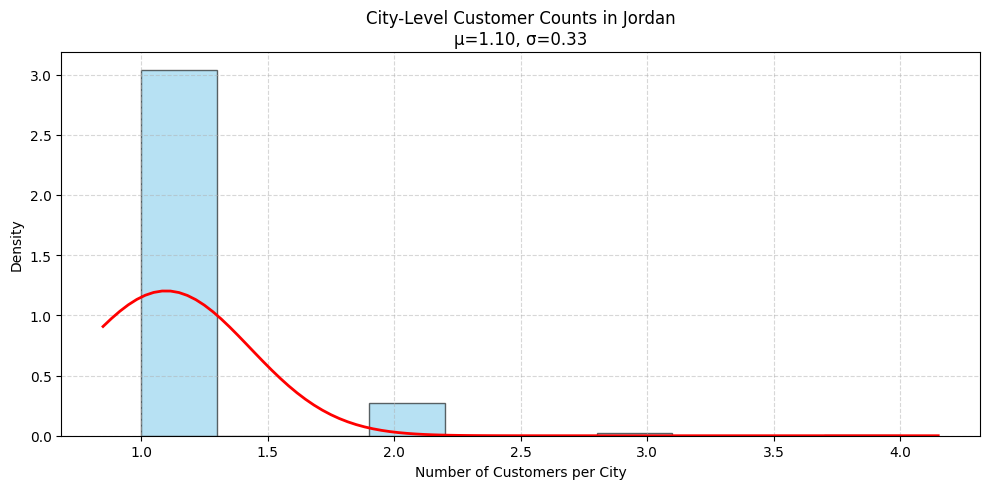

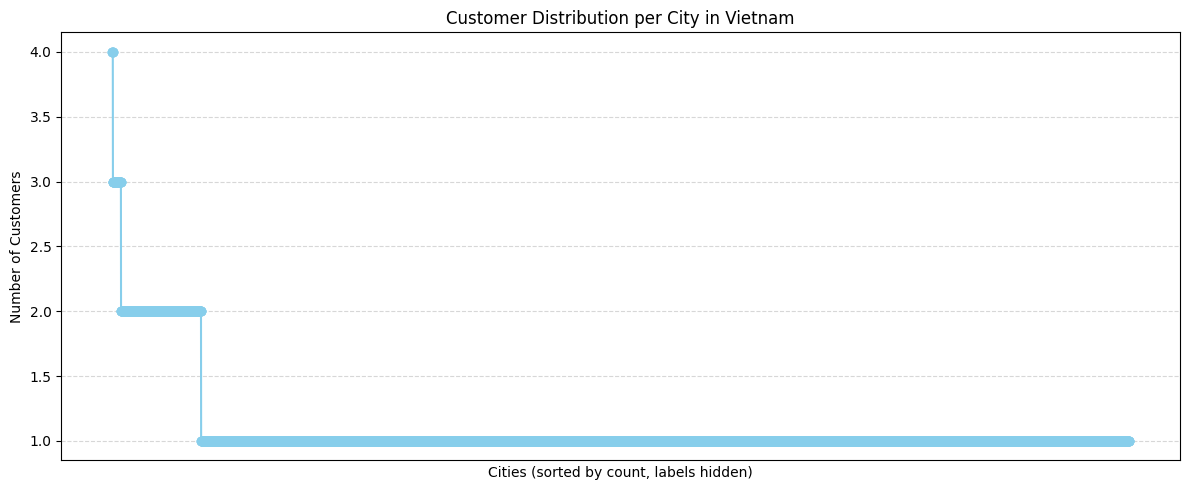

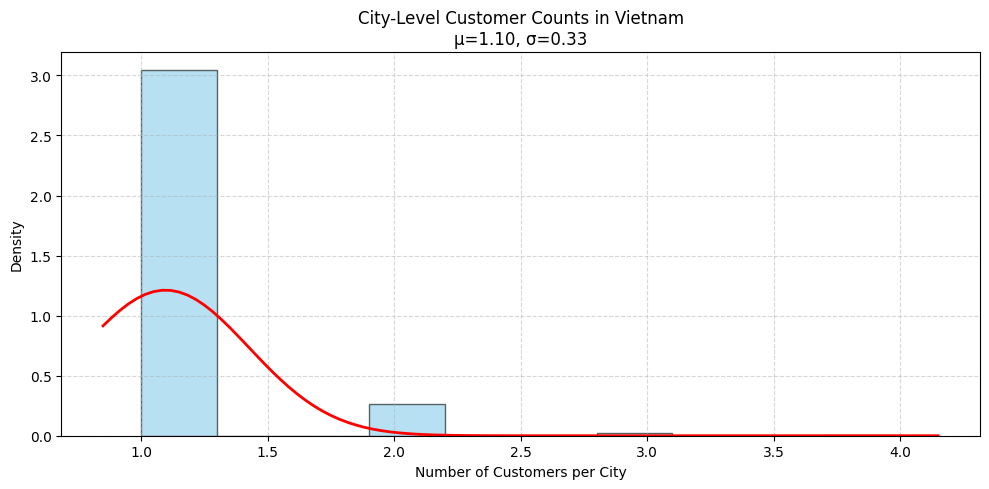

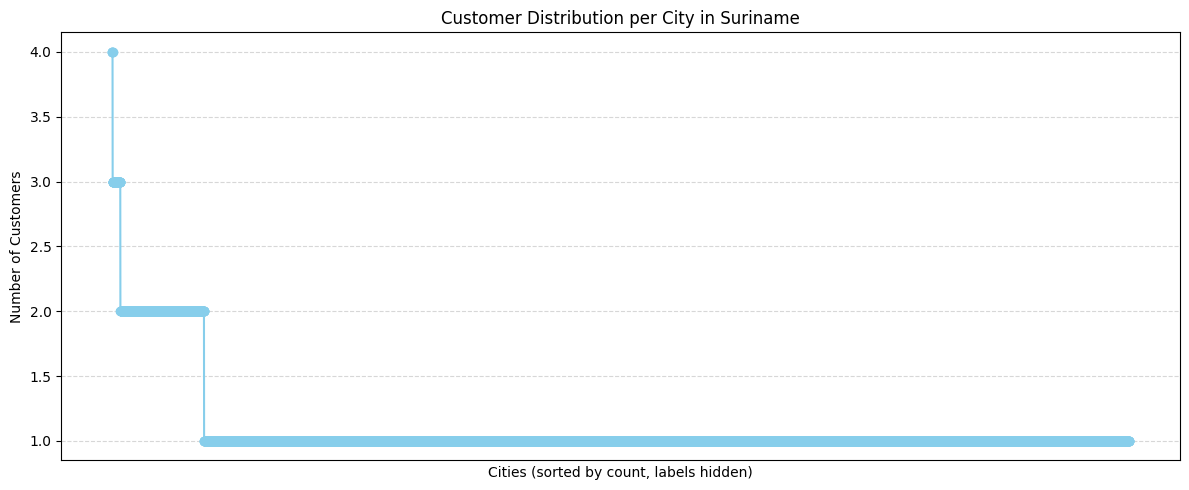

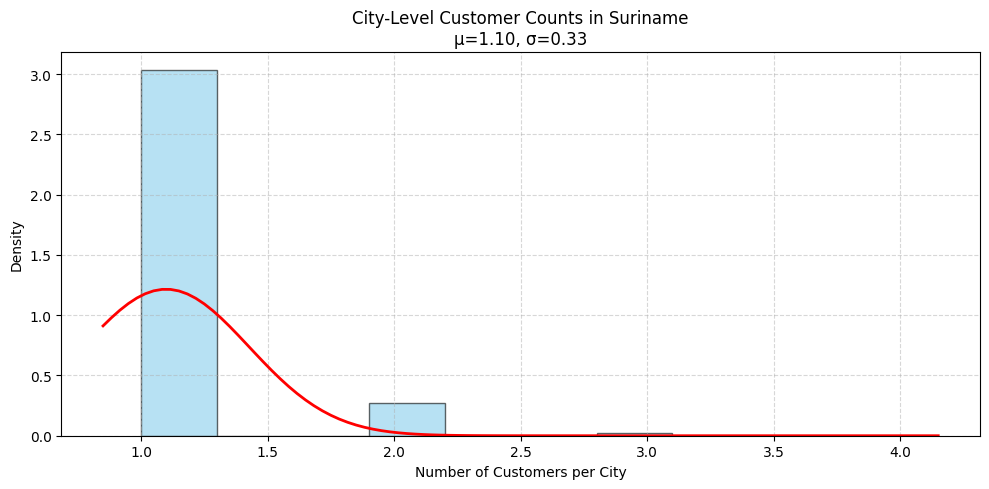


Average μ (mean) across sampled countries: 1.13
Average σ (std) across sampled countries: 0.39


In [6]:
mus, stds = [] , []

top_n = 5
top_countries_list = accounts_per_country.sort_values(ascending=False).head(top_n).index.tolist()

for country in top_countries_list:

    city_counts = city_counts_df[city_counts_df['Country'] == country][['City', 'Total']]

    data = city_counts.sort_values('Total', ascending=False)

    # Skip if fewer than 2 cities
    if len(data) < 2:
        continue

    plt.figure(figsize=(12,5))

    plt.plot(range(len(data)), data['Total'], marker='o', linestyle='-', color='skyblue')

    plt.title(f'Customer Distribution per City in {country}')
    plt.xlabel('Cities (sorted by count, labels hidden)')
    plt.ylabel('Number of Customers')
    plt.xticks([]) 
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    data_f = city_counts['Total'].values

    mu, std = norm.fit(data_f)
    mus.append(mu)
    stds.append(std)

    plt.figure(figsize=(10,5))
    plt.hist(data_f, bins=10, density=True, alpha=0.6, color='skyblue', edgecolor='black')  

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2)

    plt.title(f'City-Level Customer Counts in {country}\nμ={mu:.2f}, σ={std:.2f}')
    plt.xlabel('Number of Customers per City')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

if mus and stds:
    avg_mu = np.mean(mus)
    avg_std = np.mean(stds)
    print(f"\nAverage μ (mean) across sampled countries: {avg_mu:.2f}")
    print(f"Average σ (std) across sampled countries: {avg_std:.2f}")
else:
    print("\nNot enough data to compute averages.")




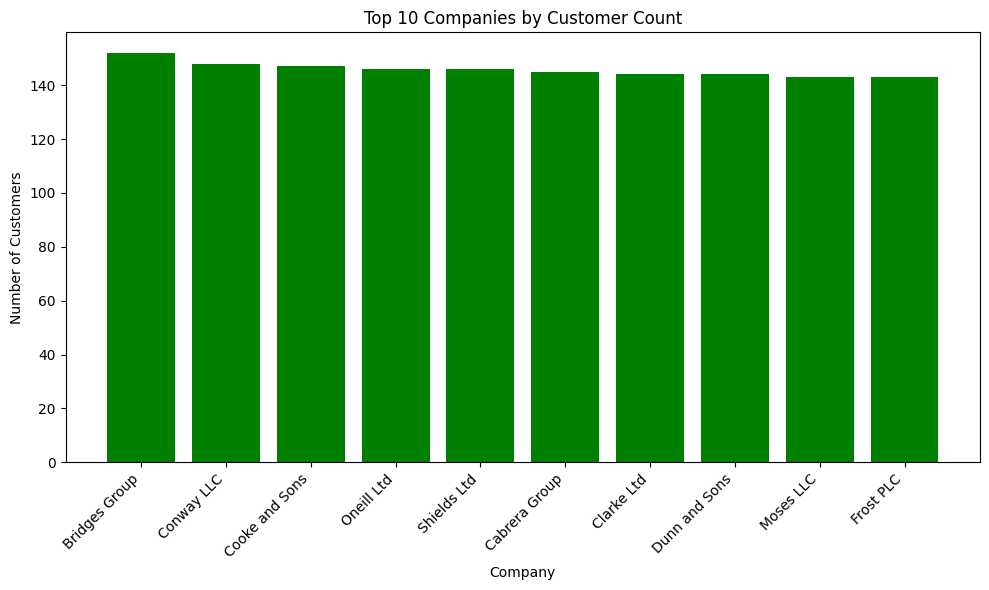

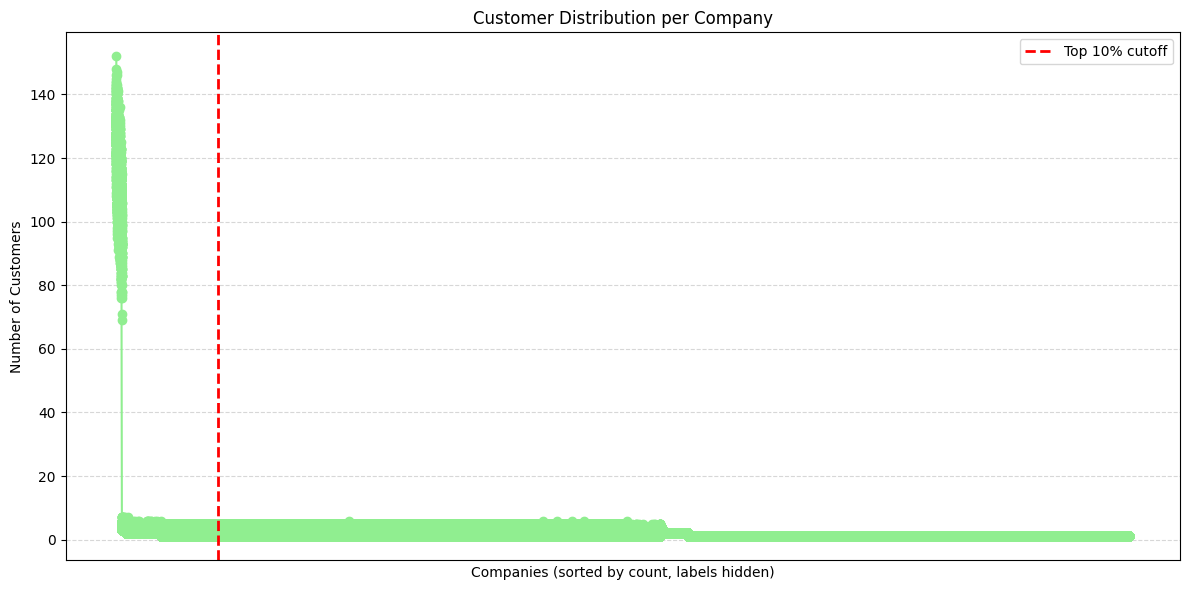

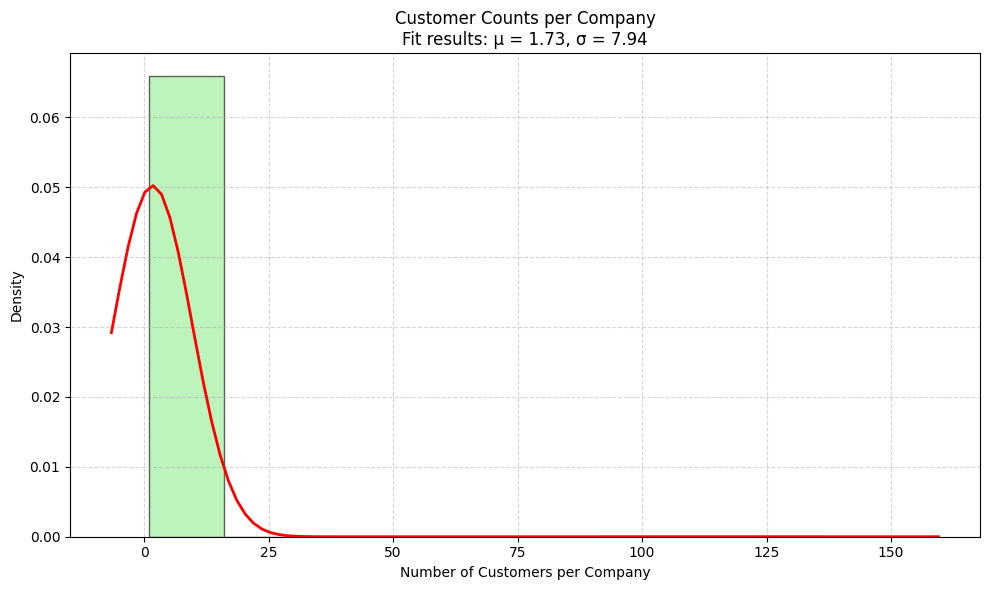

In [7]:

top_n = 10
top_k = int(0.1*len(company_counts_df))

top_companies = company_counts_df.head(top_n)  # top_n companies by Total
plt.figure(figsize=(10,6))
plt.bar(top_companies['Company'], top_companies['Total'], color='green')
plt.title(f'Top {top_n} Companies by Customer Count')
plt.xlabel('Company')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,6))
plt.plot(company_counts_df['Total'], marker='o', linestyle='-', color='lightgreen')
plt.title('Customer Distribution per Company')
plt.xlabel('Companies (sorted by count, labels hidden)')
plt.ylabel('Number of Customers')
plt.xticks([])  
plt.grid(True, linestyle='--', alpha=0.5)

plt.axvline(x=top_k-0.5, color='red', linestyle='--', linewidth=2, label='Top 10% cutoff')
plt.legend()
plt.tight_layout()
plt.show()

data = company_counts_df['Total']

mu, std = norm.fit(data)

plt.figure(figsize=(10,6))
plt.hist(data, bins=10, density=True, alpha=0.6, color='lightgreen', edgecolor='black')

# Normal curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

plt.title(f'Customer Counts per Company\nFit results: μ = {mu:.2f}, σ = {std:.2f}')
plt.xlabel('Number of Customers per Company')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


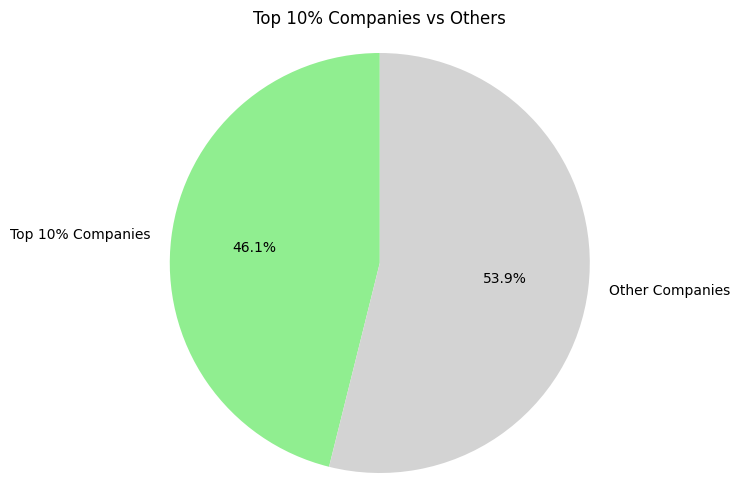

In [8]:
top_k = int(0.1 * len(company_counts_df))

# Sum of top 10% companies
top_company_sum = company_counts_df['Total'].head(top_k).sum()

other_sum = company_counts_df['Total'].iloc[top_k:].sum()

pie_data = [top_company_sum, other_sum]
labels = ['Top 10% Companies', 'Other Companies']

# Plot
plt.figure(figsize=(8,6))
plt.pie(pie_data, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightgray'], startangle=90)
plt.title('Top 10% Companies vs Others')
plt.axis('equal')
plt.show()


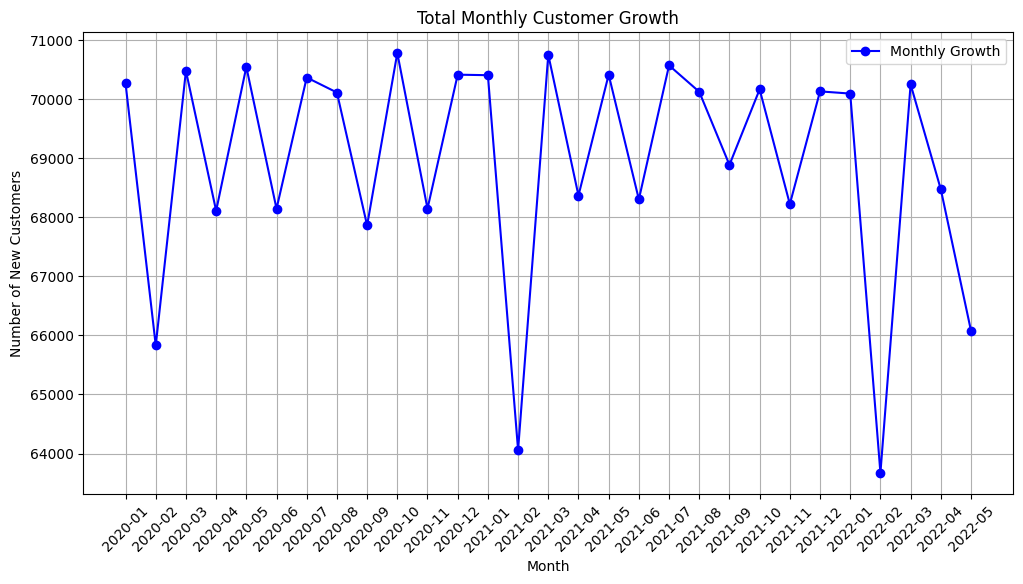

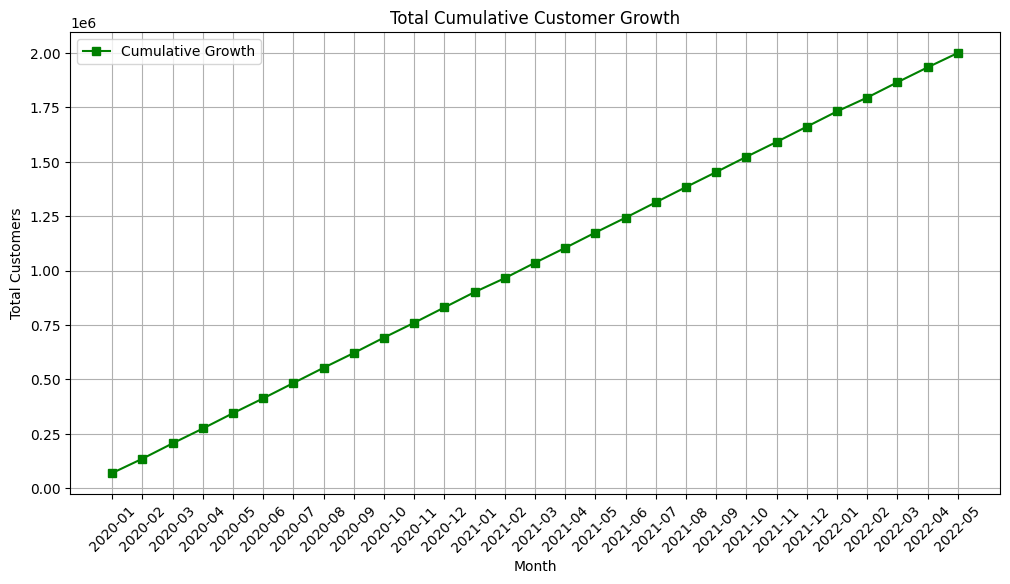

In [9]:
monthly_growth = monthly_counts_df.groupby('YearMonth')['MonthlyCount'].sum()

cumulative_growth = monthly_growth.cumsum()

plt.figure(figsize=(12,6))
plt.plot(monthly_growth.index.astype(str), monthly_growth.values, marker='o', color='blue', label='Monthly Growth')
plt.title('Total Monthly Customer Growth')
plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(cumulative_growth.index.astype(str), cumulative_growth.values, marker='s', color='green', label='Cumulative Growth')
plt.title('Total Cumulative Customer Growth')
plt.xlabel('Month')
plt.ylabel('Total Customers')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [10]:
monthly_pivot = monthly_counts_df.pivot(index='Country', columns='YearMonth', values='MonthlyCount').fillna(0)

country_avg = monthly_pivot.mean(axis=1)

monthly_deviation = monthly_pivot.sub(country_avg, axis=0)

# Inspect
monthly_deviation.head()

YearMonth,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,14.724138,9.724138,0.724138,3.724138,-14.275862,9.724138,-4.275862,-7.275862,-5.275862,20.724138,...,24.724138,4.724138,-19.275862,-21.275862,17.724138,-17.275862,-21.275862,20.724138,1.724138,-26.275862
Albania,-22.655172,9.344828,-10.655172,18.344828,-4.655172,-29.655172,12.344828,15.344828,-28.655172,14.344828,...,-13.655172,-5.655172,-5.655172,-0.655172,1.344828,-0.655172,-26.655172,11.344828,7.344828,-36.655172
Algeria,1.103448,6.103448,25.103448,-15.896552,-10.896552,-23.896552,7.103448,-7.896552,-24.896552,33.103448,...,-4.896552,7.103448,-13.896552,6.103448,4.103448,25.103448,-5.896552,14.103448,-8.896552,-31.896552
American Samoa,-18.758621,-14.758621,2.241379,3.241379,16.241379,-10.758621,34.241379,17.241379,-3.758621,16.241379,...,-15.758621,-31.758621,-0.758621,-25.758621,28.241379,-10.758621,-6.758621,19.241379,2.241379,-22.758621
Andorra,10.862069,-23.137931,-10.137931,-3.137931,-14.137931,6.862069,43.862069,7.862069,-2.137931,5.862069,...,-5.137931,-24.137931,29.862069,17.862069,2.862069,15.862069,-8.137931,-12.137931,-16.137931,-1.137931


In [11]:
# Aggregate monthly growth across all countries
total_monthly_growth = monthly_counts_df.groupby('YearMonth')['MonthlyCount'].sum()

# Top 3 growth months
top_3_months = total_monthly_growth.nlargest(3)

# Bottom 3 growth months
bottom_3_months = total_monthly_growth.nsmallest(3)

print("Top 3 growth months (total):")
print(top_3_months)

print("\nBottom 3 growth months (total):")
print(bottom_3_months)

Top 3 growth months (total):
YearMonth
2020-10    70780
2021-03    70751
2021-07    70570
Freq: M, Name: MonthlyCount, dtype: int64

Bottom 3 growth months (total):
YearMonth
2022-02    63671
2021-02    64060
2020-02    65831
Freq: M, Name: MonthlyCount, dtype: int64


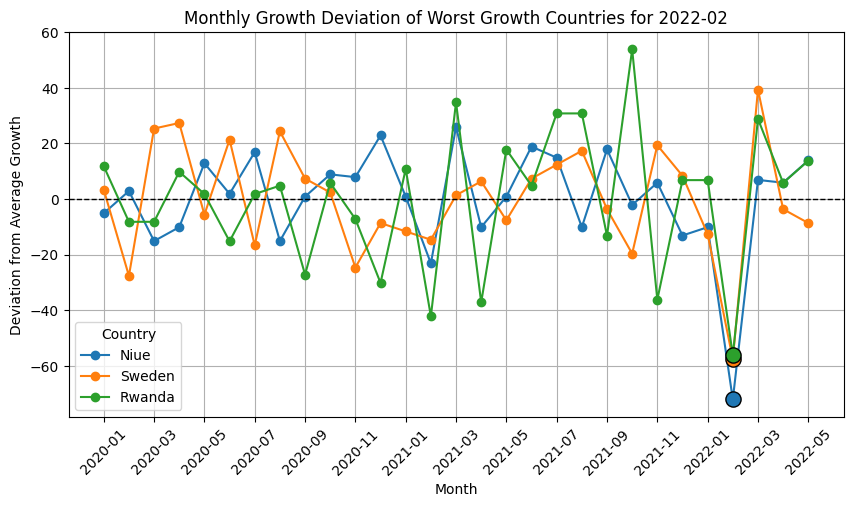

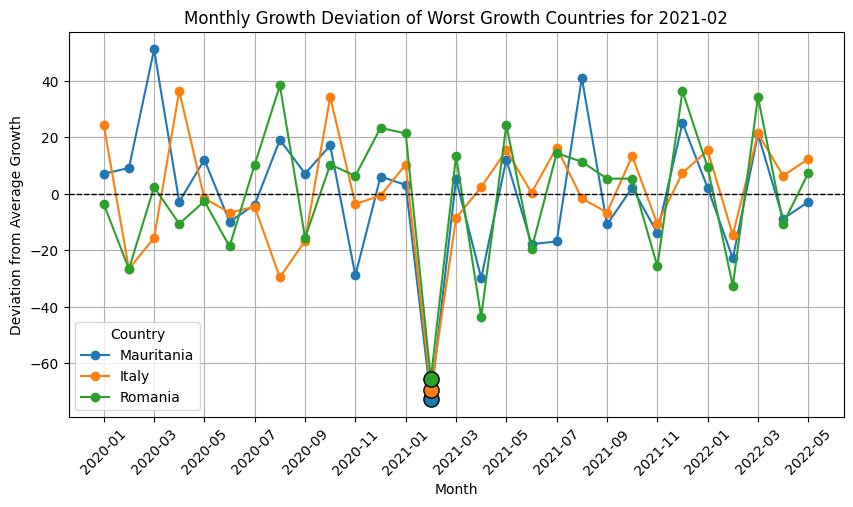

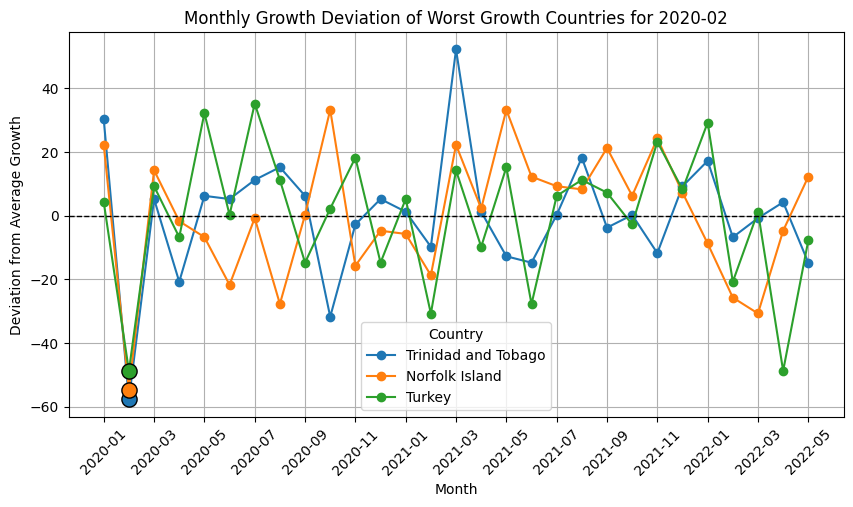

In [12]:


monthly_deviation_transposed = monthly_deviation.T

def best_worst_countries(df, months):
    month_dict = {}
    for month in months:
        month_data = df.loc[month]
        best_3 = month_data.nlargest(1).index.tolist()   # top 3 countries
        worst_3 = month_data.nsmallest(3).index.tolist() # bottom 3 countries
        month_dict[month] = {
            'Best': best_3,
            'Worst': worst_3
        }
    return month_dict

bottom_records = best_worst_countries(monthly_deviation_transposed, bottom_3_months.index)



all_months = bottom_records.keys() 

for month in all_months:
    worst_countries = bottom_records[month]['Worst']  # only worst
    plot_data = monthly_deviation.loc[worst_countries]  # rows = countries, columns = months

    plt.figure(figsize=(10,5))

    colors = sns.color_palette("tab10", n_colors=len(worst_countries))

    for country, color in zip(worst_countries, colors):
        plt.plot(plot_data.columns.astype(str), plot_data.loc[country], marker='o', label=country, color=color)

        plt.scatter(str(month), plot_data.loc[country, month], color=color, s=120, edgecolor='black', zorder=5)

    plt.axhline(0, color='black', linestyle='--', linewidth=1) 
    plt.title(f'Monthly Growth Deviation of Worst Growth Countries for {month}')
    plt.xlabel('Month')
    plt.ylabel('Deviation from Average Growth')

    all_month_labels = plot_data.columns.astype(str)
    plt.xticks(all_month_labels[::2], rotation=45)  

    plt.grid(True)
    plt.legend(title='Country')
    plt.show()